In [1]:
from gdpyt import GdpytImageCollection, GdpytCalibrationSet
from gdpyt.utils.evaluation import GdpytPerformanceEvaluation
from gdpyt.utils.nn import RotateN90, RandomBCGAdjust
from os.path import join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib notebook

In [2]:
 # Properties of the synthetic images
n_images = 40
background_noise = 20
grid = (10, 10)
particle_diameter = 2
range_z = (-40, 40)
shape = (512, 512)
#folder = r'C:\Users\silus\UCSB\master_thesis\python_stuff\gdpyt\tests\test_synthetic\DS_Grid_sigma50'
folder = r'C:\Users\silus\UCSB\master_thesis\python_stuff\gdpyt\tests\test_synthetic\DS_Grid_sigma0'
setting_file = join(folder, 'settings.txt')
testtxt_folder = join(folder, 'input')
calibtxt_folder = join(folder, 'calibration_input')
testimg_folder = join(folder, 'images')
calibimg_folder = join(folder, 'calibration_images')

## Calibration set (training set)

In [3]:
# Calibration collection and set ##################################################################################
filetype = '.tif'
processing = {
    'cv2.GaussianBlur': {'args': [(11, 11), 5]}}#,
    #'cv2.bilateralFilter': {'args': [9, 10, 10]}}

calib_collection = GdpytImageCollection(calibimg_folder, filetype, processing_specs=processing,
                                        min_particle_size=20, max_particle_size=2000)
calib_collection.uniformize_particle_ids(threshold=20)
name_to_z = {}
for image in calib_collection.images.values():
    name_to_z.update({image.filename: float(image.filename.split('_')[-1].split(filetype)[0])})

calib_set = calib_collection.create_calibration(name_to_z)

<IPython.core.display.Javascript object>


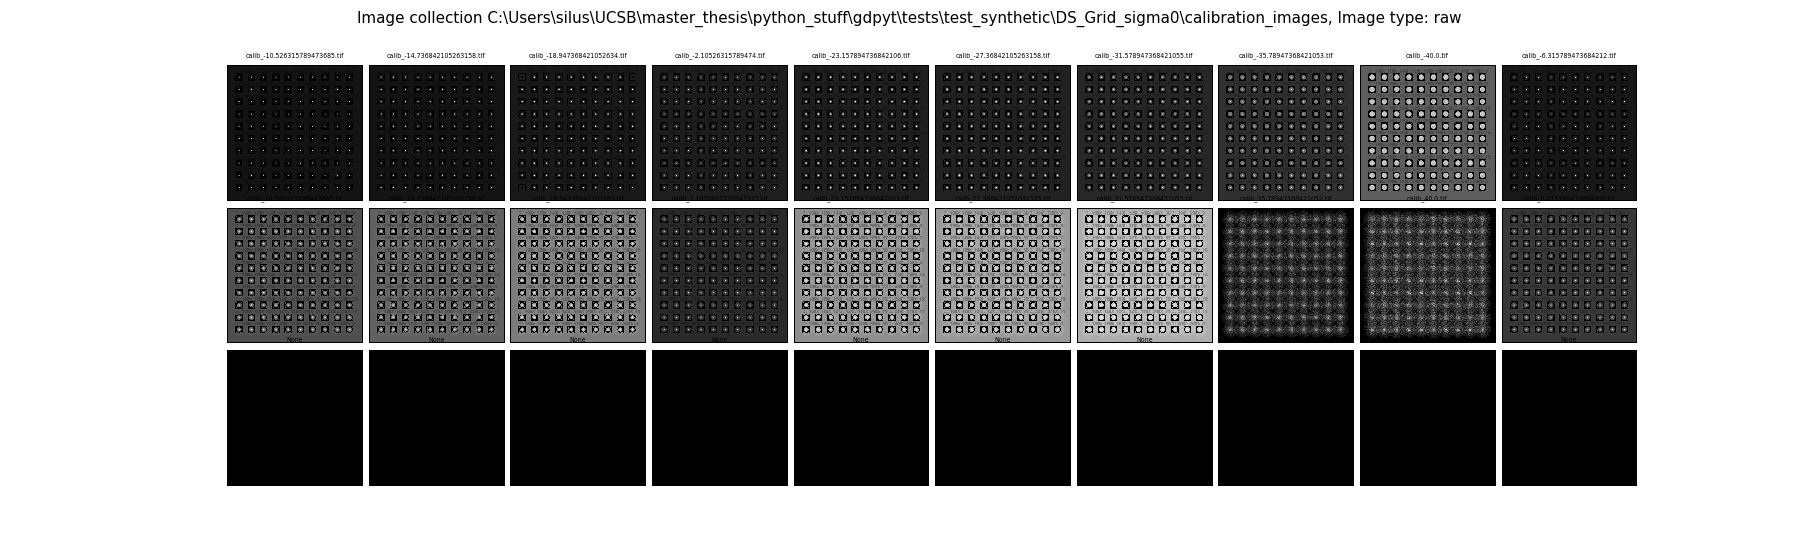

In [4]:
fig = calib_collection.plot(raw=True, draw_particles=True)
fig.show()

In [ ]:
calib_collection[5].raw

## Creating and training the CNN

**4 conv layers, 16 filters**

INFO:gdpyt.utils.nn.dataset:Max. size specified: 50. Shape of calibration set: (25, 25)
INFO:gdpyt.utils.nn.dataset:Created a GdpytTensorDataset as a training set using 1796 particles from calibration set
INFO:gdpyt.GdpytCalibrationSet:Using CPU for training
INFO:gdpyt.similarity.nn:Epoch 0: Start
INFO:gdpyt.similarity.nn:Epoch 0, Batch 0
INFO:gdpyt.similarity.nn:Epoch 0, Batch 1
INFO:gdpyt.similarity.nn:Epoch 0, Batch 2
INFO:gdpyt.similarity.nn:Epoch 0, Batch 3
INFO:gdpyt.similarity.nn:Epoch 0, Batch 4
INFO:gdpyt.similarity.nn:Epoch 0, Batch 5
INFO:gdpyt.similarity.nn:Epoch 0, Batch 6
INFO:gdpyt.similarity.nn:Epoch 0, Batch 7
INFO:gdpyt.similarity.nn:Epoch 0, Batch 8
INFO:gdpyt.similarity.nn:Epoch 0, Batch 9
INFO:gdpyt.similarity.nn:Epoch 0, Batch 10
INFO:gdpyt.similarity.nn:Epoch 0, Batch 11
INFO:gdpyt.similarity.nn:Epoch 0, Batch 12
INFO:gdpyt.similarity.nn:Epoch 0, Batch 13
INFO:gdpyt.similarity.nn:Epoch 0, Batch 14
INFO:gdpyt.similarity.nn:Epoch 0: Duration: 24.01s, Train Loss: 4.

<IPython.core.display.Javascript object>


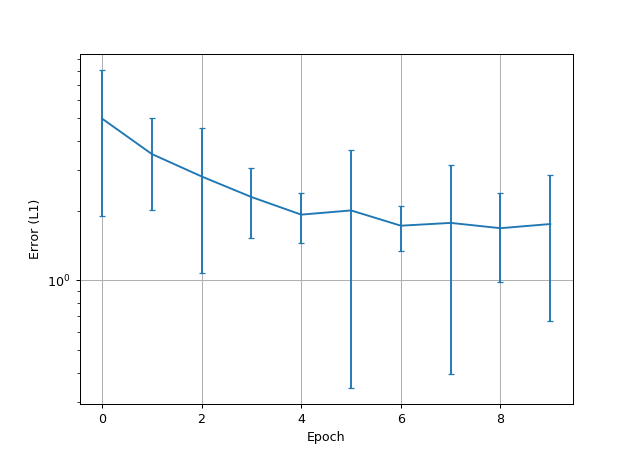

In [5]:
# Create and train CNN #######################################################################################
calib_set.create_cnn(n_conv_layers=4, n_linear_layers=2, kernel_size=5, n_filters_init=16, batch_norm=(0, 1, 2))
epochs = 10
lr = 1e-4
transforms = None #[RotateN90(), RandomBCGAdjust()]
calib_set.train_cnn(epochs, normalize_inputs=True, transforms=transforms, 
                    max_sample_size=50, skip_na=True, reg_type='l2', batch_size=128)

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(calib_set.train_summary['Epoch'], calib_set.train_summary['Avg_loss'],
            yerr=calib_set.train_summary['Sigma_loss'], capsize=2)
ax.set_ylabel('Error (L1)')
ax.set_xlabel('Epoch')
ax.grid(True)
ax.set_yscale('log')

**4 conv layers, 8 filters**

In [ ]:
# Create and train CNN #######################################################################################
calib_set.create_cnn(n_conv_layers=4, n_linear_layers=2, kernel_size=5, n_filters_init=8, batch_norm=(0, 1, 2))
epochs = 10
lr = 1e-4
calib_set.train_cnn(epochs, normalize_inputs=True, max_sample_size=50, skip_na=True, reg_type='l2')

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(calib_set.train_summary['Epoch'], calib_set.train_summary['Avg_loss'],
            yerr=calib_set.train_summary['Sigma_loss'], capsize=2)
ax.set_ylabel('Error (L1)')
ax.set_xlabel('Epoch')
ax.set_yscale('log')

**3 conv layers, 32 filters**

In [ ]:
# Create and train CNN #######################################################################################
calib_set.create_cnn(n_conv_layers=3, n_linear_layers=2, kernel_size=5, n_filters_init=32, batch_norm=(0, 1, 2))
epochs = 10
lr = 1e-4
calib_set.train_cnn(epochs, normalize_inputs=True, max_sample_size=50, skip_na=True, reg_type='l2')

fig, ax = plt.subplots(figsize=(7, 5))
ax.errorbar(calib_set.train_summary['Epoch'], calib_set.train_summary['Avg_loss'],
            yerr=calib_set.train_summary['Sigma_loss'], capsize=2)
ax.set_ylabel('Error (L1)')
ax.set_xlabel('Epoch')
ax.grid(True)
ax.set_yscale('log')

## Predict

In [ ]:
# Predict ################################################################################################
collection = GdpytImageCollection(testimg_folder, filetype, processing_specs=processing,
                                  min_particle_size=20, max_particle_size=2000)
collection.uniformize_particle_ids(baseline=calib_set, threshold=20)

collection.infer_z(calib_set, function='cnn')

In [ ]:
fig = collection.plot(raw=True, draw_particles=True)
fig.show()

## Evaluate performance

In [ ]:
# Evaluate performance #############################################################################################
perf_eval = GdpytPerformanceEvaluation(collection, testtxt_folder)
perf_eval.sigma_z()

In [ ]:
perf_eval.sigma_z_local()

In [ ]:
sz_loc = perf_eval.sigma_z_local()
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(sz_loc['z'], sz_loc['sigma_z_local'])
ax.set_ylabel(r'$\sigma_z$ [$\mu$ m]', fontsize=12)
ax.set_xlabel('Z [$\mu$ m]')
ax2 = ax.twinx()
ax2.plot(sz_loc['z'], sz_loc['sigma_z_local'] / (abs(sz_loc['z'].max()) + abs(sz_loc['z'].min())))
ax2.set_ylabel(r'$\sigma_z / h$', fontsize=16)
